In [1]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.manifold import TSNE
from mpl_toolkits.mplot3d import Axes3D
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import learning_curve

In [2]:
dataset = pd.read_csv('sentiment_data.csv', encoding='ISO-8859-1')
stemmer = pd.read_csv('stem_tl.csv')
word_to_stem = dict(zip(stemmer['word'], stemmer['stem']))

replace_patterns = {
    re.compile(r"\bngayo\'y\b"): 'ngayon ay',
    re.compile(r"\bhangga\'t\b"): 'hanggang',
    re.compile(r"\b\'?y\b"): ' ay',
    re.compile(r"\b\'?t\b"): ' at',
    re.compile(r"\b\'?yan\b"): 'iyan',
    re.compile(r"\b\'?yo\b"): 'iyo',
    re.compile(r"\b\'?yon\b"): 'iyon',
    re.compile(r"\b\'?yun\b"): 'iyun',
    re.compile(r"\b\'?pagkat\b"): 'sapagkat',
    re.compile(r"\b\'?di\b"): 'hindi',
    re.compile(r"\b\'?kaw\b"): "ikaw",
    re.compile(r"\b\'?to\b"): 'ito',
    re.compile(r"\b\'?wag\b"): 'huwag',
    re.compile(r"\bgano\'n\b"): 'ganoon'
}


display(dataset.head())

text sentiment
0                     Ako si Kaliwa.   neutral
1               Kapatid ko si Kanan.   neutral
2  Hinubog kami mula sa iisang goma.   neutral
3             Iisa ang aming itsura.   neutral
4       Magkasinggaan, magkasinlaki.   neutral

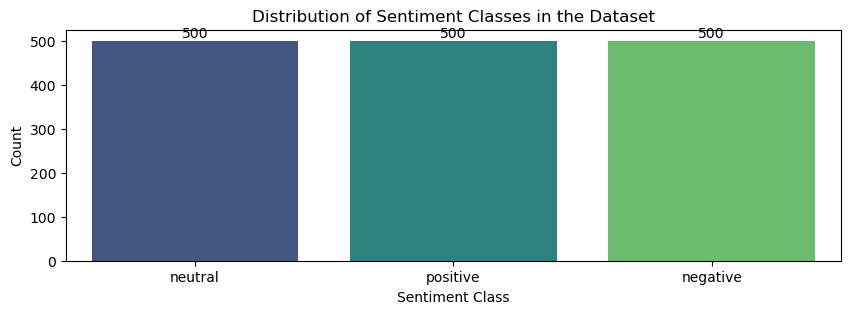

In [3]:
class_counts = dataset['sentiment'].value_counts()

plt.figure(figsize=(10, 3))
sns.countplot(x='sentiment', data=dataset, order=class_counts.index, palette='viridis')

plt.title('Distribution of Sentiment Classes in the Dataset')
plt.xlabel('Sentiment Class')
plt.ylabel('Count')

for i, count in enumerate(class_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

In [4]:
def data_preprocess(text, replace_patterns, word_to_stem):
    text = text.lower()

    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)

    text = re.sub("[^a-zA-Z0-9\s?!.]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens])

    return text

dataset['text_preprocessed'] = dataset['text'].apply(data_preprocess, replace_patterns=replace_patterns, word_to_stem=word_to_stem)

display(dataset.head(10))

text sentiment  \
0                                     Ako si Kaliwa.   neutral   
1                               Kapatid ko si Kanan.   neutral   
2                  Hinubog kami mula sa iisang goma.   neutral   
3                             Iisa ang aming itsura.   neutral   
4                       Magkasinggaan, magkasinlaki.   neutral   
5                Ako si Kanan, kapatid ko si Kaliwa.   neutral   
6  Sabay kaming binili ng nanay ni Carlo sa Divis...   neutral   
7   Iisa ang aming porma. Magkakulay. Magkasintibay.   neutral   
8             Maghapon ay nag-uunahan kami ni Kanan.   neutral   
9            Maghapon ay nag-iiwanan kami ni Kaliwa.   neutral   

                                   text_preprocessed  
0                                    ako si kaliwa .  
1                              kapatid ko si kanan .  
2                 hinubog kami mula sa iisang goma .  
3                            iisa ang aming itsura .  
4                       magkasinggaan magkasinlaki .  
5                ako si kanan kapatid ko si kaliwa .  
6  sabay kami binili ng nanay ni carlo sa divisor...  
7  iisa ang aming porma . magkakulay . magkasinti...  
8                hapon ay naguunahan kami ni kanan .  
9               hapon ay nagiiwanan kami ni kaliwa .

In [5]:
# Define X and y
X = dataset['text_preprocessed']
y = dataset['sentiment']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a CountVectorizer to convert text into a matrix of token counts
vectorizer = CountVectorizer()
X_train_counts = vectorizer.fit_transform(X_train)
X_test_counts = vectorizer.transform(X_test)

# Apply TF-IDF transformation
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train_counts)
X_test_tfidf = tfidf_transformer.transform(X_test_counts)

# Train an SVM classifier
knn_clf = KNeighborsClassifier()
knn_clf.fit(X_train_tfidf, y_train)

# Predict on the test set
y_pred = knn_clf.predict(X_test_tfidf)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.68
Classification Report:
              precision    recall  f1-score   support

    negative       0.60      0.65      0.62       110
     neutral       0.79      0.63      0.70       104
    positive       0.69      0.77      0.73        86

    accuracy                           0.68       300
   macro avg       0.69      0.69      0.68       300
weighted avg       0.69      0.68      0.68       300



C:\Users\Anna Margarita\anaconda3\lib\site-packages\sklearn\neighbors\_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)


In [52]:
pipeline = Pipeline([
    ('vectorizer', CountVectorizer()),
    ('tfidf_transformer', TfidfTransformer()),
    ('svm_clf', SVC(kernel='linear'))
])

# Define parameters for grid search
parameters = {
    'svm_clf__C': [0.1, 1, 10]  # Adjust as needed
}

# Perform grid search
grid_search = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best model
best_model = grid_search.best_estimator_

# Predict on the test set using the best model
y_pred = best_model.predict(X_test)

# Evaluate the best model
accuracy = accuracy_score(y_test, y_pred)
print("Best Model Accuracy:", accuracy)
print("Best Model Parameters:", grid_search.best_params_)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Best Model Accuracy: 0.7433333333333333
Best Model Parameters: {'svm_clf__C': 1}
Classification Report:
              precision    recall  f1-score   support

    negative       0.74      0.56      0.64       110
     neutral       0.79      0.89      0.84       104
    positive       0.69      0.79      0.74        86

    accuracy                           0.74       300
   macro avg       0.74      0.75      0.74       300
weighted avg       0.74      0.74      0.74       300



In [37]:
def preprocess_input(text):
    text = text.lower()
    for pattern, replacement in replace_patterns.items():
        text = pattern.sub(replacement, text)
    text = re.sub("[^a-zA-Z0-9\s?!]", '', text)
    tokens = word_tokenize(text)
    text = ' '.join([word_to_stem.get(word, word) for word in tokens])
    return text

def predict_sentiment(input_text):
    # Preprocess input text
    preprocessed_text = preprocess_input(input_text)
    
    # Vectorize and transform input text
    input_text_counts = vectorizer.transform([preprocessed_text])
    input_text_tfidf = tfidf_transformer.transform(input_text_counts)
    
    # Predict sentiment
    sentiment = svm_clf.predict(input_text_tfidf)
    
    return sentiment[0]

# Example usage:
user_input = input("Enter your text: ")
predicted_sentiment = predict_sentiment(user_input)
print("Predicted sentiment:", predicted_sentiment)


Enter your text: masaya akong makita ka ngayon
Predicted sentiment: positive
